In [60]:
%load_ext nb_black
import numpy as np 
import matplotlib.pyplot as plt
import pickle

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [61]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape 
    out_h = (H + 2 * pad - filter_h) // stride + 1 
    out_w = (W + 2 * pad - filter_w) // stride + 1 

    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w 
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col 

<IPython.core.display.Javascript object>

In [62]:
def naive_im2col(image, filter_h, filter_w):
    img_h, img_w = image.shape 
    out_h = img_h - filter_h + 1 
    out_w = img_w - filter_w + 1
    col = np.zeros((filter_h * filter_w, out_h * out_w))
    for h in range(out_h):
        for w in range(out_w):
            col[:, w + h * out_w] = image[h : h + filter_w, w : w + filter_w].reshape(-1)
    return col

x = np.arange(1, 17).reshape(4, 4)
f = np.arange(-4, 0).reshape(2, 2)
print(naive_im2col(x, 2, 2))
print(naive_im2col(f, 2, 2).T)
print(naive_im2col(f, 2, 2).T @ naive_im2col(x, 2, 2))

[[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]
[[-4. -3. -2. -1.]]
[[ -26.  -36.  -46.  -66.  -76.  -86. -106. -116. -126.]]


<IPython.core.display.Javascript object>

In [63]:
import time 
y = np.zeros((28, 28))
start = time.time()
for i in range(1000):
    naive_im2col(y, 2, 2)
end = time.time()
print(f"time: {end - start}")

time: 0.6777710914611816


<IPython.core.display.Javascript object>

In [64]:
def naive_im2col_v2(image, filter_h, filter_w):
    img_h, img_w = image.shape 
    out_h = img_h - filter_h + 1
    out_w = img_w - filter_w + 1
    col = np.zeros((filter_h, filter_w, out_h, out_w))
    for h in range(filter_h):
        for w in range(filter_w):
            col[h, w, :, :] = image[h : h + out_h, w : w + out_w]
    return col.reshape(filter_h * filter_w, out_h * out_w)

x = np.arange(1, 17).reshape(4, 4)
f = np.arange(-4, 0).reshape(2, 2)
print(naive_im2col_v2(x, 2, 2))
print(naive_im2col_v2(f, 2, 2).T)
print(naive_im2col_v2(f, 2, 2).T @ naive_im2col_v2(x, 2, 2))

y = np.zeros((28, 28))
start = time.time()
for i in range(1000):
    naive_im2col_v2(y, 2, 2)
end = time.time()
print("time: {}".format(end - start))

[[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]
[[-4. -3. -2. -1.]]
[[ -26.  -36.  -46.  -66.  -76.  -86. -106. -116. -126.]]
time: 0.004269838333129883


<IPython.core.display.Javascript object>

In [65]:
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


<IPython.core.display.Javascript object>

In [96]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape 
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

<IPython.core.display.Javascript object>

In [101]:
class Convolution:
    def __init__(self, w, b, stride=1, pad=0):
        self.w = w 
        self.b = b 
        self.stride = stride
        self.pad = pad 

        self.x = None 
        self.col = None 
        self.col_w = None 
        self.dw = None 
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.w.shape 
        N, C, H, W = x.shape 
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_w = self.w.reshape(FN, -1).T 
        out = np.dot(col, col_w) + self.b 

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x 
        self.col = col 
        self.col_w = col_w
        return out

    def backward(self, dout):
        FN, C, FH, FW = self.w.shape 
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dw = np.dot(self.col.T, dout)
        self.dw = self.dw.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_w.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        return

<IPython.core.display.Javascript object>

In [102]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride 
        self.pad = pad 

        self.x = None 
        self.arg_max = None 

    def forward(self, x):
        N, C, H, W = x.shape 
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # (N, C, OH, OW)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # (N, C, OH, OW)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x 
        self.arg_max = arg_max
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size, ))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        return dx   

<IPython.core.display.Javascript object>

In [107]:
from layers import Relu, Affine, SoftmaxWithLoss
from collections import OrderedDict


class SimpleConvNet:
    def __init__(
        self,
        input_dim=(1, 28, 28),
        conv_param={"filter_num": 30, "filter_size": 5, "pad": 0, "stride": 1},
        hidden_size=100,
        output_size=10,
        weight_init_std=0.01,
    ):
        filter_num = conv_param["filter_num"]
        filter_size = conv_param["filter_size"]
        filter_pad = conv_param["pad"]
        filter_stride = conv_param["stride"]
        input_size = input_dim[1]
        conv_output_size = (
            input_size - filter_size + 2 * filter_pad
        ) // filter_stride + 1
        pool_output_size = (
            filter_num * (conv_output_size // 2) * (conv_output_size // 2)
        )

        self.params = {
            "w1": weight_init_std
            * np.random.randn(filter_num, input_dim[0], filter_size, filter_size),
            "b1": np.zeros(filter_num),
            "w2": weight_init_std * np.random.randn(pool_output_size, hidden_size),
            "b2": np.zeros(hidden_size),
            "w3": weight_init_std * np.random.randn(hidden_size, output_size),
            "b3": np.zeros(output_size),
        }

        self.layers = OrderedDict()
        self.layers["Conv1"] = Convolution(
            self.params["w1"],
            self.params["b1"],
            conv_param["stride"],
            conv_param["pad"],
        )
        self.layers["Relu1"] = Relu()
        self.layers["Pool1"] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers["Affine1"] = Affine(self.params["w2"], self.params["b2"])
        self.layers["Relu2"] = Relu()
        self.layers["Affine2"] = Affine(self.params["w3"], self.params["b3"])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {
            "w1": self.layers["Conv1"].dw,
            "b1": self.layers["Conv1"].db,
            "w2": self.layers["Affine1"].dw,
            "b2": self.layers["Affine1"].db,
            "w3": self.layers["Affine2"].dw,
            "b3": self.layers["Affine2"].db,
        }
        return grads

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        acc = 0.0 
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i * batch_size : (i + 1) * batch_size]
            tt = t[i * batch_size : (i + 1) * batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]


<IPython.core.display.Javascript object>

In [108]:
from mnist import load_mnist
from trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

max_epochs = 20

network = SimpleConvNet(
    input_dim=(1, 28, 28),
    conv_param={"filter_num": 30, "filter_size": 5, "pad": 0, "stride": 1},
    hidden_size=100,
    output_size=10,
    weight_init_std=0.01,
)

trainer = Trainer(
    network,
    x_train,
    t_train,
    x_test,
    t_test,
    epochs=max_epochs,
    mini_batch_size=100,
    optimizer="Adam",
    optimizer_param={"lr": 0.001},
    evaluate_sample_num_per_epoch=1000,
)
trainer.train()


train loss:2.298772258651825
=== epoch:1, train acc:0.106, test acc:0.119 ===
train loss:2.297002099195513
train loss:2.290245401962719
train loss:2.2866673517201126
train loss:2.275383265058307
train loss:2.2640594985212137
train loss:2.2316374006854813
train loss:2.230562924773169
train loss:2.2223972775229694
train loss:2.1919069192170446
train loss:2.1712525072088606
train loss:2.112856131360257
train loss:2.063302403161611
train loss:2.0201835747270196
train loss:1.9971041498102111
train loss:1.9270913809393482
train loss:1.8359504403913645
train loss:1.7340271013031947
train loss:1.6768525156879373
train loss:1.5257421006906504
train loss:1.6545627443878272
train loss:1.4433314596370965
train loss:1.3637016312278056
train loss:1.2659147138523712
train loss:1.1964755562477545
train loss:1.219196164782566
train loss:1.0821448764038564
train loss:0.9947774342868521
train loss:0.936988184246169
train loss:0.8531012305427171
train loss:0.7600107506024506
train loss:0.9157025912466469


<IPython.core.display.Javascript object>

In [109]:
def save_params(network, file_name="params.pkl"):
    params = {}
    for key, val in network.params.items():
        params[key] = val 
    with open(file_name, "wb") as f:
        pickle.dump(params, f)

def load_params(network, file_name="params.pkl"):
    with open(file_name, "rb") as f:
        params = pickle.load(f)
    for key, val in params.items():
        network.params[key] = val 

    for i, key in enumerate(["Conv1", "Affine1", "Affine2"]):
        network.layers[key].w = network.params['w' + str(i + 1)]
        network.layers[key].b = network.params['b' + str(i + 1)]

<IPython.core.display.Javascript object>

In [110]:
save_params(network)

<IPython.core.display.Javascript object>

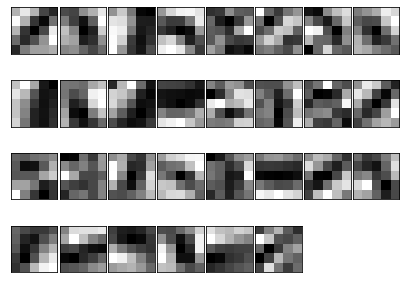

<IPython.core.display.Javascript object>

In [113]:
def show_filter(filters, nx=8, margin=3, scale=10):
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i + 1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation="nearest")
    plt.show()

show_filter(network.params["w1"])